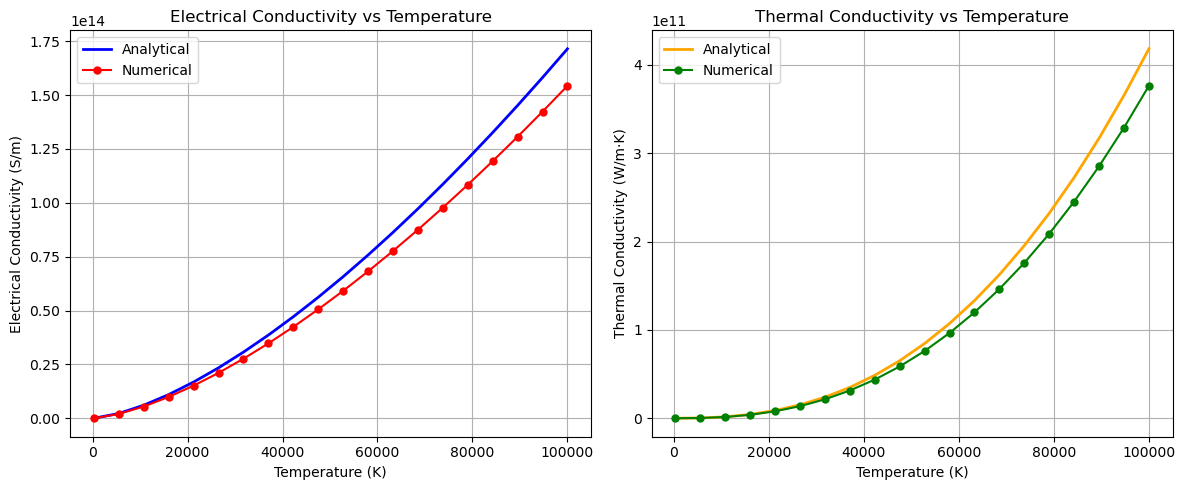

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
n = 1e28      # electron density (m^-3)
e = 1.602e-19 # electron charge (C)
m = 9.11e-31  # electron mass (kg)
L = 2.44e-8   # Lorenz number (W·Ω·K^-2)
nu0 = 1e10    # reference collision frequency (s^-1)
T0 = 300      # reference temperature (K)
E_field = 1.0 # constant electric field (V/m)

# Temperature range
T = np.linspace(300, 1e5, 20)

# --- Analytical Solution ---
nu_e_anal = nu0 * (T / T0)**(-1.5)  # collision frequency
tau_anal = 1 / nu_e_anal            # relaxation time
sigma_anal = (n * e**2 * tau_anal) / m  # electrical conductivity
kappa_anal = L * sigma_anal * T     # thermal conductivity

# --- Numerical Solution ---
sigma_num = []
num_points = 1000  # reduced for efficiency, since t_span is dynamic

for temp in T:
    nu_e = nu0 * (temp / T0)**(-1.5)  # collision frequency at this T
    tau = 1 / nu_e                    # relaxation time
    t_span = [0, 10 * tau]            # time span: 10 relaxation times
    t_eval = np.linspace(t_span[0], t_span[1], num_points)  # time points
    
    # Define ODE: m dv/dt = eE - m nu_e v
    def ode(t, v):
        return (e * E_field - m * nu_e * v) / m
    
    # Solve ODE numerically
    sol = solve_ivp(ode, t_span, [0], t_eval=t_eval, method='RK45')
    v = sol.y[0]  # velocity over time
    
    # Compute average velocity numerically (trapezoidal rule)
    v_avg = np.trapz(v, t_eval) / (t_span[1] - t_span[0])
    
    # Compute sigma = n e <v> / E
    j = n * e * v_avg  # current density
    sigma = j / E_field
    sigma_num.append(sigma)

sigma_num = np.array(sigma_num)
kappa_num = L * sigma_num * T  # thermal conductivity

# --- Plotting ---
plt.figure(figsize=(12, 5))

# Electrical Conductivity Plot
plt.subplot(1, 2, 1)
plt.plot(T, sigma_anal, label='Analytical', color='blue', linewidth=2)
plt.plot(T, sigma_num, 'o-', label='Numerical', color='red', markersize=5)
plt.xlabel('Temperature (K)')
plt.ylabel('Electrical Conductivity (S/m)')
plt.title('Electrical Conductivity vs Temperature')
plt.grid(True)
plt.legend()

# Thermal Conductivity Plot
plt.subplot(1, 2, 2)
plt.plot(T, kappa_anal, label='Analytical', color='orange', linewidth=2)
plt.plot(T, kappa_num, 'o-', label='Numerical', color='green', markersize=5)
plt.xlabel('Temperature (K)')
plt.ylabel('Thermal Conductivity (W/m·K)')
plt.title('Thermal Conductivity vs Temperature')
plt.grid(True)
plt.legend()

# Adjust layout and save
plt.tight_layout()
plt.savefig('conductivities_comparison.png')
plt.show()

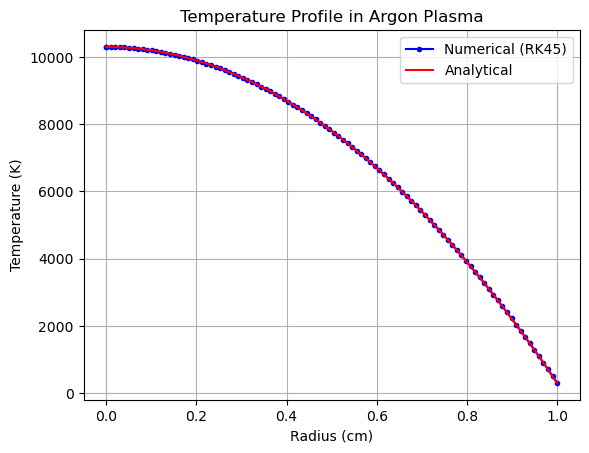

Analytical T(0): 10300.00 K
T(R) numerical: 300.00 K (should be 300.0 K)
Max difference from analytical: 2.04e-07 K


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
R = 1.0  # cm
T_0 = 300.0  # K
E = 1000.0  # V/cm
sigma = 4000.0  # ohm^-1 cm^-1
kappa = 1e5  # erg/(s·cm·K)
r_span = (1e-6, R)  # Avoid r=0 singularity
N = 100

# Analytical solution
sigma_E2_over_kappa = sigma * E**2 / kappa
T_max_analytical = T_0 + (sigma_E2_over_kappa / 4) * R**2

# ODE system
def dTdr(r, y):
    T, S = y
    dT_dr = S
    dS_dr = -sigma_E2_over_kappa - S / r if r > 0 else 0  # Handle r=0
    return [dT_dr, dS_dr]

# Initial conditions: T(0) = guess, S(0) = 0
T0_guess = T_max_analytical  # Start with analytical max
initial_conditions = [T0_guess, 0.0]

# Solve using RK45
sol = solve_ivp(dTdr, r_span, initial_conditions, method='RK45', 
                t_eval=np.linspace(r_span[0], R, N))

# Extract numerical solution
r_num = sol.t
T_num = sol.y[0]

# Include r=0 explicitly
r_num = np.insert(r_num, 0, 0)
T_num = np.insert(T_num, 0, T0_guess)

# Analytical solution for comparison
T_analytical = T_0 + (sigma_E2_over_kappa / 4) * (R**2 - r_num**2)

# Plot results
plt.plot(r_num, T_num, 'b.-', label='Numerical (RK45)')
plt.plot(r_num, T_analytical, 'r-', label='Analytical')
plt.xlabel('Radius (cm)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Profile in Argon Plasma')
plt.legend()``
plt.grid(True)
plt.show()

# Verify boundary condition and max difference
print(f"Analytical T(0): {T_max_analytical:.2f} K")  # Should be ~10300 K
print(f"T(R) numerical: {T_num[-1]:.2f} K (should be {T_0} K)")
print(f"Max difference from analytical: {np.max(np.abs(T_num - T_analytical)):.2e} K")